In [1]:
import numpy as np
import pandas as pd

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal

import re
import warnings
# import ('../../../utils.py')
warnings.filterwarnings('ignore')


# Utils

## Functions

### Feature Selection

In [2]:
def get_fc_dict(df,class_label,metab_num):
    df=df.copy(deep=True)
    means = df.groupby(class_label).mean()
    fold_changes = means.iloc[1] / means.iloc[0] 
    fc_dict=dict(zip(df.columns.tolist(),fold_changes))
    return fc_dict,means
    # 计算fold change
    fold_changes = means.iloc[1] / means.iloc[0] 
def get_pvalue_dict(df,label_cols,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set(label_cols)-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict


# Analysis

## 20240419

In [3]:
sample_df=pd.read_csv('../../Subtype/results/20240406/cluster_7e-2.csv',index_col=0)
sample_df

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters
1452,1,1,1,2
8339,1,1,1,2
5608,1,1,1,2
8232,3,3,2,1
8775,2,3,2,1
...,...,...,...,...
140143-T,1,2,1,2
190040-T,1,2,1,2
190161-T,3,2,2,2
200288-T,3,2,2,1


### RNA seq

In [4]:
rna_df=pd.read_csv('../data/rna/genes.csv',index_col=0)
print(rna_df.shape)
print(rna_df.columns)
rna_df=rna_df.reset_index().rename(columns={'cccc':'Sample Name'}).set_index('Sample Name')

# Rename columns
pattern = r"[Ca|T]([\d]+)"
new_columns=[]
for colname in rna_df.columns:
    id_string=re.search(pattern,colname).group(1)
    if 'T' in colname:
        new_colname=str(id_string)+'-T'
    else:
        new_colname=str(id_string)
    new_columns.append(new_colname)
new_columns
rna_df.rename(columns=dict(zip(rna_df.columns,new_columns)),inplace=True)
rna_df=rna_df.T
rna_df.astype(int)

print(f"data size is {rna_df.shape}")

# rna_df.to_csv('../data/rna/counts.csv')

(58818, 111)
Index(['count.Ca1277', 'count.Ca1364', 'count.Ca1452', 'count.Ca1520',
       'count.Ca1649', 'count.Ca1775', 'count.Ca1870', 'count.Ca1900',
       'count.Ca2039', 'count.Ca2139',
       ...
       'count.T200095', 'count.T200097', 'count.T200128', 'count.T200131',
       'count.T200288', 'count.T200297', 'count.T210011', 'count.T210012',
       'count.T222836', 'count.T271431'],
      dtype='object', length=111)
data size is (111, 58818)


In [5]:
rna_df.index=rna_df.index.str.replace('Ca','')
def replace_index(text):
  pattern = r"T(\d+)"
  repl = r"\1-T"
  new_text = re.sub(pattern, repl, text)

In [6]:
counts_df=rna_df.copy(deep=True)

In [7]:
display(counts_df.head())
rna_df.dtypes

Sample Name,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288634,ENSG00000288635,ENSG00000288636,ENSG00000288637,ENSG00000288638,ENSG00000288639,ENSG00000288640,ENSG00000288642,ENSG00000288644,ENSG00000288645
1277,77,0,19,125,38,96,0,50,492,0,...,2,0,1,5,0,0,0,7,0,0
1364,1443,0,942,1420,1792,112,241,1240,1482,1638,...,1,0,0,97,191,0,0,0,1,1
1452,297,7,712,1323,1901,141,252,930,249,2249,...,1,0,0,200,393,0,142,0,1,4
1520,1102,22,841,1968,1588,2029,4576,2183,2601,3123,...,1,0,0,87,3,0,80,0,1,1
1649,531,5,998,1889,2306,296,136,483,1567,2317,...,1,3,0,257,85,0,0,0,1,1


Sample Name
ENSG00000000003    int64
ENSG00000000005    int64
ENSG00000000419    int64
ENSG00000000457    int64
ENSG00000000460    int64
                   ...  
ENSG00000288639    int64
ENSG00000288640    int64
ENSG00000288642    int64
ENSG00000288644    int64
ENSG00000288645    int64
Length: 58818, dtype: object

In [8]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))

#### Prepare Data

In [9]:
print(f"data size is {counts_df.shape}")
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
counts_df=counts_df.loc[sample_indexes]
counts_sample_df=sample_df.loc[sample_indexes]
print(f"data size is {counts_df.shape}")

data size is (111, 58818)
data size is (92, 55963)


In [10]:
# Replace with your actual sample information (e.g., control vs. treatment)
condition_series = sample_df.loc[:,['kmeans_2_clusters']]


In [11]:
inference = DefaultInference(n_cpus=64)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=counts_sample_df,
    design_factors="kmeans_2_clusters",
    refit_cooks=True,
    inference=inference,
)
# Create a DESeq2 dataset (DESeqDataSet)


In [12]:
dds.deseq2()


Fitting size factors...
... done in 0.11 seconds.

Fitting dispersions...
... done in 6.86 seconds.

Fitting dispersion trend curve...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 7.65 seconds.

Fitting LFCs...
... done in 5.39 seconds.

Replacing 6997 outlier genes.

Fitting dispersions...
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 0.99 seconds.

Fitting LFCs...
... done in 1.06 seconds.



In [15]:
using_df=pd.merge(counts_df,sample_df,left_index=True,right_index=True)
using_df.groupby('kmeans_2_clusters').mean()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288637,ENSG00000288638,ENSG00000288639,ENSG00000288640,ENSG00000288642,ENSG00000288644,ENSG00000288645,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters
kmeans_2_clusters,,,,,,,,,,,,,,,,,,,,,
1,1275.292683,11.170732,699.658537,1661.804878,1741.463415,534.024390,2109.902439,1422.634146,4856.390244,2473.463415,...,139.536585,252.878049,0.365854,53.048780,0.170732,0.975610,4.170732,2.707317,2.536585,2.00000
2,1098.392157,9.980392,648.843137,1669.803922,2009.941176,302.588235,949.254902,880.294118,2547.156863,2565.980392,...,152.078431,240.725490,0.372549,25.627451,0.549020,0.980392,5.647059,1.392157,1.686275,1.27451


In [16]:
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

Running Wald tests...
... done in 3.56 seconds.



Log2 fold change & Wald test p-value: kmeans-2-clusters 2 vs 1
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Sample Name                                                                  
ENSG00000000003  1115.117110       -0.119829  0.233131 -0.513997  0.607254   
ENSG00000000005     9.959599       -0.085123  0.438573 -0.194092  0.846104   
ENSG00000000419   599.428725       -0.033217  0.169015 -0.196535  0.844191   
ENSG00000000457  1556.931533        0.055492  0.124240  0.446655  0.655124   
ENSG00000000460  1784.631575        0.270922  0.192267  1.409090  0.158809   
...                      ...             ...       ...       ...       ...   
ENSG00000288639     0.350525        0.090469  0.593585  0.152411  0.878863   
ENSG00000288640    29.263922       -1.534772  1.258796 -1.219238  0.222754   
ENSG00000288642     0.287546        1.095881  2.973333  0.368570  0.712448   
ENSG00000288644     0.916655        0.077380  0.329272  0.235002  0.814207   
E

In [17]:
rna_stat_result_df=stat_res.results_df
# rna_stat_result_df.to_csv('../results/20240419/rna_stat.csv')

In [18]:
rna_sd_df=rna_stat_result_df[(abs(rna_stat_result_df['log2FoldChange'])>=1)&(rna_stat_result_df['padj']<=5e-2)]


#### Result

In [20]:
print("#Ensembl Gene logFC")
for i in rna_sd_df.index:
    print(f"{i} {rna_sd_df.loc[i,'log2FoldChange']}")

#Ensembl Gene logFC
ENSG00000000971 -1.00707143032077
ENSG00000003400 -1.3814084049563622
ENSG00000003436 -1.2186552311968601
ENSG00000004468 -1.1417298873127866
ENSG00000004846 1.9698176079902443
ENSG00000004848 1.8069655194444492
ENSG00000005001 -1.3341738766242355
ENSG00000005844 -1.2158542667236685
ENSG00000006283 1.6413541700475012
ENSG00000006377 1.06725461105542
ENSG00000007129 -1.4550509469139894
ENSG00000007216 -2.1902802396378664
ENSG00000007312 -1.9142300379876722
ENSG00000007372 1.560973341885722
ENSG00000008517 -1.3344207714613716
ENSG00000009790 -1.2623882836277591
ENSG00000010295 -1.0193183232980907
ENSG00000010610 -1.1711165774059347
ENSG00000010671 -1.0031543534547063
ENSG00000010932 -1.1444974812886577
ENSG00000011332 1.25976062237648
ENSG00000012124 -1.5355826595572388
ENSG00000012223 -1.4539922021931613
ENSG00000013588 -1.6525206784063304
ENSG00000013725 -1.1825611127707014
ENSG00000014257 -1.1212809608132248
ENSG00000017427 -1.3227419910413183
ENSG00000018280 -1.41

##### Up

In [21]:
print("#Ensembl Gene logFC")
for i in rna_sd_df[rna_sd_df['log2FoldChange']>0].index:
    print(f"{i} {rna_sd_df.loc[i,'log2FoldChange']}")

#Ensembl Gene logFC
ENSG00000004846 1.9698176079902443
ENSG00000004848 1.8069655194444492
ENSG00000006283 1.6413541700475012
ENSG00000006377 1.06725461105542
ENSG00000007372 1.560973341885722
ENSG00000011332 1.25976062237648
ENSG00000029559 1.8045734603203991
ENSG00000036448 1.1359578611680428
ENSG00000041515 1.5476879575172322
ENSG00000049089 1.2552554667752518
ENSG00000050438 1.1779498534181865
ENSG00000054179 1.011861654279288
ENSG00000055813 1.1198243851052894
ENSG00000063515 2.1333169214357173
ENSG00000066230 1.472126924015063
ENSG00000067840 1.3424651017245477
ENSG00000077274 1.6326538222765539
ENSG00000077279 1.4776117631247827
ENSG00000081842 1.0416531751975797
ENSG00000083067 1.507480075731355
ENSG00000084628 1.1634517324921907
ENSG00000090097 1.1960505491978872
ENSG00000092051 1.7288195819071972
ENSG00000092758 1.8060717809310876
ENSG00000095981 1.7977766376747117
ENSG00000099617 2.5927389080142733
ENSG00000099625 1.3096449339356386
ENSG00000099864 1.4380231323144896
ENSG0000

##### Down

In [22]:
print("#Ensembl Gene logFC")
for i in rna_sd_df[rna_sd_df['log2FoldChange']<0].index:
    print(f"{i} {rna_sd_df.loc[i,'log2FoldChange']}")

#Ensembl Gene logFC
ENSG00000000971 -1.00707143032077
ENSG00000003400 -1.3814084049563622
ENSG00000003436 -1.2186552311968601
ENSG00000004468 -1.1417298873127866
ENSG00000005001 -1.3341738766242355
ENSG00000005844 -1.2158542667236685
ENSG00000007129 -1.4550509469139894
ENSG00000007216 -2.1902802396378664
ENSG00000007312 -1.9142300379876722
ENSG00000008517 -1.3344207714613716
ENSG00000009790 -1.2623882836277591
ENSG00000010295 -1.0193183232980907
ENSG00000010610 -1.1711165774059347
ENSG00000010671 -1.0031543534547063
ENSG00000010932 -1.1444974812886577
ENSG00000012124 -1.5355826595572388
ENSG00000012223 -1.4539922021931613
ENSG00000013588 -1.6525206784063304
ENSG00000013725 -1.1825611127707014
ENSG00000014257 -1.1212809608132248
ENSG00000017427 -1.3227419910413183
ENSG00000018280 -1.419781232712908
ENSG00000019186 -1.465736190096098
ENSG00000019582 -1.1634607047926826
ENSG00000023445 -1.5991523176340705
ENSG00000026103 -1.3355332691064132
ENSG00000026751 -1.7818789311976497
ENSG00000026

In [ ]:
print(dds)


AnnData object with n_obs × n_vars = 92 × 55559
    obs: 'nmf_3_clusters', 'kmeans_3_clusters', 'nmf_2_clusters', 'kmeans-2-clusters'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'


In [50]:

# Perform library size normalization
dds = dds.normalize()


AttributeError: 'DeseqDataSet' object has no attribute 'normalize'

### Metab

#### Prepare Data

In [25]:
name_map_df=pd.read_csv('../data/kegg/kegg_name_map.csv')
name_map_df['compound']=name_map_df['compound'].str.lower()
name_map_df['match']=name_map_df['Match'].str.lower()
unfind_metab_compounds=['2-hydroxygluterate','d-sedoheptulose-1-7-phosphate','hexose-phosphate']
unfind_metab_hmdbs=['HMDB0000606','HMDB0304323','HMDB0001401']
for index in range(len(unfind_metab_compounds)):
    new_row={'compound':unfind_metab_compounds[index],'HMDB':unfind_metab_hmdbs[index]}
    name_map_df = pd.concat([name_map_df, pd.DataFrame([new_row])], ignore_index=True)

# name_map_df.to_csv('../data/kegg/kegg_name_map.csv')

In [26]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
metab_df=metab_df.rename(columns=dict(zip(metab_df.columns,metab_df.columns.str.lower())))
metab_num=metab_df.shape[1]
class_label='kmeans_2_clusters'
# metab_df.to_csv('../../Subtype/data/Using/metab.csv')

In [27]:
using_df=pd.merge(metab_df,sample_df.loc[:,[class_label]],left_index=True,right_index=True)

In [28]:
metab_stat_df=pd.DataFrame.from_dict(get_pvalue_dict(using_df,['kmeans_2_clusters']),orient='index',columns=['pvalue'])
fc_dict,mean_df=get_fc_dict(using_df,class_label,metab_num)
metab_stat_df['fc']=fc_dict
metab_stat_df['log2fc']=np.log2(metab_stat_df.fc)

[1, 2]


In [37]:
mean_df.apply(sum,axis=1)

kmeans_2_clusters
1    8.036953e+09
2    8.038375e+09
dtype: float64

In [35]:
display(mean_df)

,2-aminooctanoic acid,2-deoxyglucose-6-phosphate,2-hydroxy-2-methylbutanedioic acid,2-hydroxygluterate,2-isopropylmalic acid,2-ketohexanoic acid,2-keto-isovalerate,3-phosphoglycerate,4-aminobutyrate,4-phosphopantothenate,...,udp-n-acetyl-glucosamine,ump,urea,uric acid,uridine,utp,valine,xanthine,xanthosine,xanthurenic acid
kmeans_2_clusters,,,,,,,,,,,,,,,,,,,,,
1,5.331787e+06,125524.587828,688139.131405,2.666089e+06,4.036070e+07,204354.939038,2.318327e+06,1.137802e+06,171401.719607,82609.040991,...,1.943476e+07,7.444527e+06,1.140606e+07,9.355014e+06,2.532365e+06,5.511877e+06,404664.078771,7.932143e+06,633486.224604,88768.428259
2,5.405319e+06,89434.605052,589676.360059,2.279562e+06,3.503116e+07,167755.927140,2.399514e+06,6.877065e+05,171469.123860,69125.013403,...,1.960259e+07,8.427185e+06,1.023129e+07,8.068821e+06,3.077179e+06,4.166477e+06,448105.257006,5.612907e+06,489187.165130,83410.507934


In [29]:
metab_stat_df

,pvalue,fc,log2fc
nadp+_neg,3.582152e-01,1.064827,0.090619
d-erythrose-4-phosphate,2.560950e-08,0.458564,-1.124804
ribose-phosphate,9.212071e-04,0.773892,-0.369795
methylcysteine,1.547551e-01,1.062044,0.086844
phenyllactic acid,2.096893e-02,0.630647,-0.665096
...,...,...,...
7-methylguanosine,1.198011e-01,1.187157,0.247511
nadh_pos,1.707245e-01,0.880040,-0.184360
s-adenosyl-l-homocysteine_neg,5.979448e-07,1.861946,0.896811
cytidine,9.939427e-06,1.881569,0.911936


In [30]:
# metab_stat_df.to_csv('../results/20240419/metab_stat.csv')

#### Unfindable
- 2-hydroxygluterate 
    - 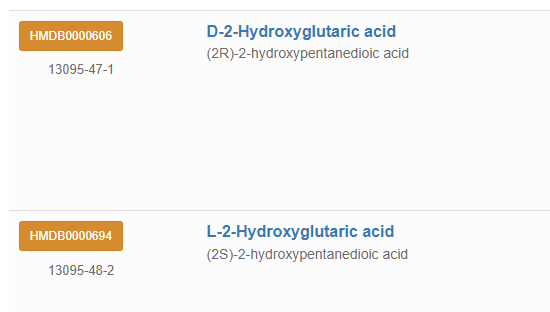
    - D-2-Hydroxyglutaric acid HMDB0000606
    - L-2-Hydroxyglutaric acid HMDB0000694
- d-sedoheptulose-1-7-phosphate
    - HMDB0304323
- 2-deoxyglucose-6-phosphate
- hexose-phosphate
    - Glucose 6-phosphate HMDB0001401




In [31]:
# Unfindable
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    i=i.replace("_pos","")
    i=i.replace("_neg","")
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            print(i)
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

2-deoxyglucose-6-phosphate


#### Result 

In [32]:
metab_stat_df.fillna(0,inplace=True)

In [33]:
for i in metab_stat_df.index:
    if i.endswith("_neg"):
        pair_idx=i[:-4] + '_pos'
        if pair_idx in metab_stat_df.index:
            if abs(metab_stat_df.loc[i, 'log2fc']) < abs(metab_stat_df.loc[pair_idx, 'log2fc']):
                metab_stat_df.drop(i, inplace=True)
            else:
                metab_stat_df.drop(pair_idx, inplace=True)
    elif i.endswith("_pos"):
        i=i[:-4]
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    # print(i)
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            # print(i)
            continue
        else:
            print(f"{i} {name_map_df[name_map_df['match']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
            continue
    else:
        # print(f"{name_map_df[name_map_df['compound']==i].compound.values[0]} {name_map_df[name_map_df['compound']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
            print(f"{name_map_df[name_map_df['compound']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

HMDB0001321 -1.1248037659404326
HMDB0001548 -0.3697953827202283
HMDB0000779 -0.665096460442242
HMDB0000058 -0.6891441145873269
HMDB0001397 0.5103263257825768
HMDB0000060 0.3064526326745049
HMDB0000201 -0.19184108934194896
HMDB0000742 2.765122332608023
HMDB0000684 -1.0491831335768818
HMDB0001367 -0.6557691130770833
cholesterol sulfate HMDB0000653 -0.638537485901657
HMDB0000296 0.28112280579205695
HMDB0000232 -2.274380464220022
HMDB0304323 -0.7941325462364157
HMDB0000195 -0.5714140476883123
HMDB0001112 -0.7675960347515856
HMDB0000645 -0.664693572594094
HMDB0000161 0.284687116280698
HMDB0000807 -0.7263849541010272
HMDB0001202 0.2971462456719184
HMDB0000128 0.2219060308497183
HMDB0000446 0.2544145397049222
HMDB0000045 0.20168138281292466
HMDB0000157 -0.23119126806521287
HMDB0000299 -0.3729266955842368
HMDB0000167 0.26655828614109456
HMDB0000133 -0.4706937590340666
HMDB0001440 -0.3489797385270248
HMDB0000034 0.3574740613710943
HMDB0000115 -0.2691015122578115
HMDB0001494 -0.359895672147636
H

In [34]:
metab_stat_df.loc["HMDB0000653",'log2fc']

KeyError: 'HMDB0000653'

In [ ]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))